## Setup

In [1]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import gc

from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from fastkde.fastKDE import fastKDE
from scipy.stats import linregress

from harp_resources import process, utils
from sleap import load_and_process as lp


# symbols to use ✅ ℹ️ ⚠️ ❗

In [3]:
############################################################################################################
# set up variables and load data 
############################################################################################################

plot_timeseries = False
score_cutoff = 0.2 # for checking prediction accuracy
outlier_sd_threshold = 10 # for removing outliers from the data

# for saccades
framerate = 59.77  # Hz (in the future, should come from saved data)
threshold = 65  # px/s FIXME make this adaptive
refractory_period = pd.Timedelta(milliseconds=100)  # msec, using pd.Timedelta for datetime index
plot_saccade_detection_QC = True

data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/Visual_mismatch_day3/B6J2717-2024-12-10T12-17-03')
save_path = data_path.parent / f"{data_path.name}_processedData"

print ("\n❗ ❗ ❗ if SleapData.csv was already saved in the VideoData folder, this will break. Delete the file if you want to rerun processing\n")
VideoData1, VideoData2, VideoData1_Has_Sleap, VideoData2_Has_Sleap = lp.load_videography_data(data_path)

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']
coordinates_dict=lp.get_coordinates_dict(VideoData1, columns_of_interest)


❗ ❗ ❗ if SleapData.csv was already saved in the VideoData folder, this will break. Delete the file if you want to rerun processing

ℹ️ Make sure the SLEAP files follow this convention: VideoData1_1904-01-01T00-00-00.sleap.csv

Outputs of SLEAP found in VideoData1: True
Outputs of SLEAP found in VideoData2: False
Found .csv VideoData logs timestamped at:
- 1904-01-06T01:00:00.000000000
- 1904-01-06T02:00:00.000000000
ℹ️ VideoData1 has 238 dropped frames. Filling missing frames with empty rows.


In [7]:
framerate = 1/VideoData1["Seconds"].diff().mean() # calculated mean frame rate
print (framerate)

59.77165380437805


In [4]:
############################################################################################################
# plot timeseries of coordinates in borwser 
############################################################################################################
if plot_timeseries:
    print(f'⚠️ Check for long discontinouties and outsiders in the data, we will try to deal with them later')
    print(f'ℹ️ Figure opens in browser window, takes a bit of time.')
    fig = make_subplots(
        rows=4, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=(
            "X coordinates for pupil centre add left-right eye corner",
            "Y coordinates for pupil centre add left-right eye corner",
            "X coordinates for iris points",
            "Y coordinates for iris points"
        )
    )

    # Row 1: Plot left.x, center.x, right.x
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['left.x'], mode='lines', name='left.x'), row=1, col=1)
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['center.x'], mode='lines', name='center.x'), row=1, col=1)
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['right.x'], mode='lines', name='right.x'), row=1, col=1)

    # Row 2: Plot left.y, center.y, right.y
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['left.y'], mode='lines', name='left.y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['center.y'], mode='lines', name='center.y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['right.y'], mode='lines', name='right.y'), row=2, col=1)

    # Row 3: Plot p.x coordinates for p1 to p8
    for col in ['p1.x', 'p2.x', 'p3.x', 'p4.x', 'p5.x', 'p6.x', 'p7.x', 'p8.x']:
        fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=3, col=1)

    # Row 4: Plot p.y coordinates for p1 to p8
    for col in ['p1.y', 'p2.y', 'p3.y', 'p4.y', 'p5.y', 'p6.y', 'p7.y', 'p8.y']:
        fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=4, col=1)

    fig.update_layout(
        height=1200,
        title_text="Time series subplots for coordinates",
        showlegend=True
    )
    fig.update_xaxes(title_text="Seconds", row=4, col=1)
    fig.update_yaxes(title_text="X Position", row=1, col=1)
    fig.update_yaxes(title_text="Y Position", row=2, col=1)
    fig.update_yaxes(title_text="X Position", row=3, col=1)
    fig.update_yaxes(title_text="Y Position", row=4, col=1)

    fig.show(renderer='browser')

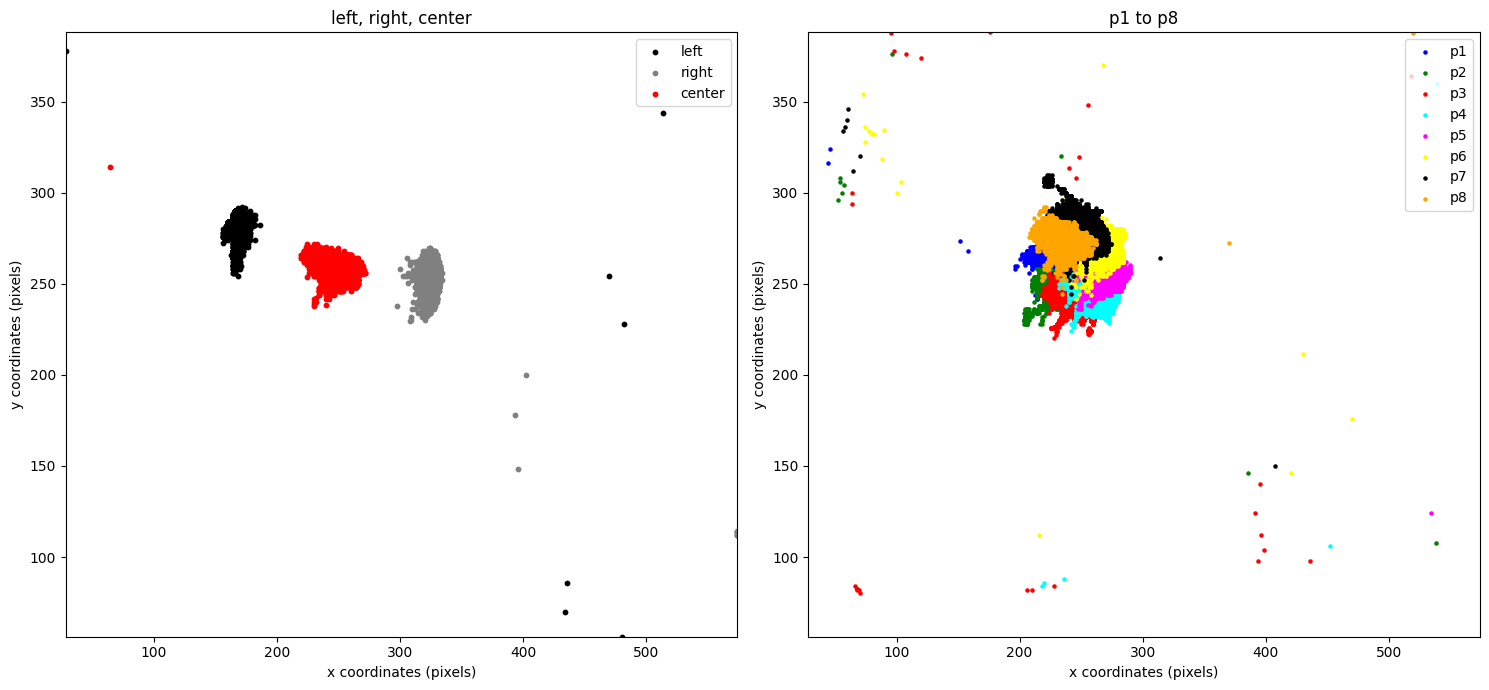

In [5]:
columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']

# Filter out NaN values and calculate the min and max values for X and Y coordinates
x_min = min([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].min() for col in columns_of_interest])
x_max = max([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].max() for col in columns_of_interest])
y_min = min([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].min() for col in columns_of_interest])
y_max = max([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].max() for col in columns_of_interest])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Plot left, right, and center in the first plot
ax[0].set_title('left, right, center')
ax[0].scatter(coordinates_dict['left.x'], coordinates_dict['left.y'], color='black', label='left', s=10)
ax[0].scatter(coordinates_dict['right.x'], coordinates_dict['right.y'], color='grey', label='right', s=10)
ax[0].scatter(coordinates_dict['center.x'], coordinates_dict['center.y'], color='red', label='center', s=10)
ax[0].set_xlim([x_min, x_max])
ax[0].set_ylim([y_min, y_max])
ax[0].set_xlabel('x coordinates (pixels)')
ax[0].set_ylabel('y coordinates (pixels)')
ax[0].legend(loc='upper right')

# Plot p1 to p8 in the second plot with different colors and smaller markers
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']
for idx, col in enumerate(columns_of_interest[3:]):
    ax[1].scatter(coordinates_dict[f'{col}.x'], coordinates_dict[f'{col}.y'], color=colors[idx], label=col, s=5)

ax[1].set_xlim([x_min, x_max])
ax[1].set_ylim([y_min, y_max])
ax[1].set_title('p1 to p8')
ax[1].set_xlabel('x coordinates (pixels)')
ax[1].set_ylabel('y coordinates (pixels)')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


In [6]:
############################################################################################################
# deal with frames where all points are NaN
############################################################################################################

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

all_nan_df = VideoData1[VideoData1[columns_of_interest].isnull().all(1)]
all_nan_index_array = all_nan_df.index.values

# print the groups of sequential NaNs
group_counts = {'1-5': 0, '6-10': 0, '>10': 0}
i = 1
for group in lp.find_sequential_groups(all_nan_index_array):
    #print(f'NaN frame group {i} with {len(group)} elements')
    if 1 <= len(group) <= 5:
        group_counts['1-5'] += 1
    elif 6 <= len(group) <= 10:
        group_counts['6-10'] += 1
    else:
        group_counts['>10'] += 1
        print(f'⚠️ Framegroup {i} has {len(group)} consecutive all NaN frames  with indices {group}. If this is a long group, consider checking the data.')
    i += 1

print(f"Framegroups with 1-5 consecutive all NaN frames: {group_counts['1-5']}")
print(f"Framegroups with 6-10 consecutive all NaN frames: {group_counts['6-10']}")
print(f"Framegroups with >10 consecutive all NaN frames: {group_counts['>10']}")

############################################################################################################
# check if we can use some filtering on scores to remove bad frames
############################################################################################################

score_cutoff = 0.2
columns_of_interest = ['left.score','center.score','right.score','p1.score','p2.score','p3.score','p4.score','p5.score','p6.score','p7.score','p8.score']
total_points = len(VideoData1)
print(f'\nℹ️ Number of frames and consequitve sequences below {score_cutoff} confidence score.')

for col in columns_of_interest:
    count_below_threshold = (VideoData1[col] < score_cutoff).sum()
    percentage_below_threshold = (count_below_threshold / total_points) * 100
    
    # Find the longest consecutive series below threshold
    below_threshold = VideoData1[col] < score_cutoff
    longest_series = 0
    current_series = 0
    
    for value in below_threshold:
        if value:
            current_series += 1
            if current_series > longest_series:
                longest_series = current_series
        else:
            current_series = 0
    
    print(f"Column: {col} | Values below {score_cutoff}: {count_below_threshold} ({percentage_below_threshold:.2f}%) | Longest consecutive frame series: {longest_series}")



⚠️ Framegroup 52 has 15 consecutive all NaN frames  with indices [67494, 67495, 67496, 67497, 67498, 67499, 67500, 67501, 67502, 67503, 67504, 67505, 67506, 67507, 67508]. If this is a long group, consider checking the data.
⚠️ Framegroup 53 has 15 consecutive all NaN frames  with indices [67517, 67518, 67519, 67520, 67521, 67522, 67523, 67524, 67525, 67526, 67527, 67528, 67529, 67530, 67531]. If this is a long group, consider checking the data.
Framegroups with 1-5 consecutive all NaN frames: 51
Framegroups with 6-10 consecutive all NaN frames: 8
Framegroups with >10 consecutive all NaN frames: 2

ℹ️ Number of frames and consequitve sequences below 0.2 confidence score.
Column: left.score | Values below 0.2: 2422 (2.17%) | Longest consecutive frame series: 360
Column: center.score | Values below 0.2: 436 (0.39%) | Longest consecutive frame series: 294
Column: right.score | Values below 0.2: 4258 (3.81%) | Longest consecutive frame series: 101
Column: p1.score | Values below 0.2: 385 (

### SLEAP processing

In [7]:
############################################################################################################
# center coordinates on median pupil centre 
############################################################################################################

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

# Calculate the mean of the center x and y points
mean_center_x = VideoData1['center.x'].median()
mean_center_y = VideoData1['center.y'].median()

print(f"Mean center.x: {mean_center_x}, Mean center.y: {mean_center_y}")

# Translate the coordinates
for col in columns_of_interest:
    if '.x' in col:
        VideoData1[col] = VideoData1[col] - mean_center_x
    elif '.y' in col:
        VideoData1[col] = VideoData1[col] - mean_center_y

############################################################################################################
# remove outliers (x times SD) and interpolate between the previous and subsequent non-NaN value
############################################################################################################

# Calculate the standard deviation for each column of interest
std_devs = {col: VideoData1[col].std() for col in columns_of_interest}

# Calculate the number of outliers for each column
outliers = {col: ((VideoData1[col] - VideoData1[col].mean()).abs() > 10 * std_devs[col]).sum() for col in columns_of_interest}

# Find the channel with the maximum number of outliers
max_outliers_channel = max(outliers, key=outliers.get)
max_outliers_count = outliers[max_outliers_channel]

# Print the channel with the maximum number of outliers and the number
print(f"Channel with the maximum number of outliers: {max_outliers_channel}, Number of outliers: {max_outliers_count}")

# Print the total number of outliers
total_outliers = sum(outliers.values())
print(f"A total number of {total_outliers} outliers will be replaced by interpolation")

# Replace outliers by interpolating between the previous and subsequent non-NaN value
for col in columns_of_interest:
    outlier_indices = VideoData1[((VideoData1[col] - VideoData1[col].mean()).abs() > outlier_sd_threshold * std_devs[col])].index
    VideoData1.loc[outlier_indices, col] = np.nan

#VideoData1.interpolate(inplace=True)
VideoData1 = VideoData1.interpolate(method='linear', limit_direction='both')

Mean center.x: 247.86394500732422, Mean center.y: 259.92156982421875
Channel with the maximum number of outliers: p3.y, Number of outliers: 28
A total number of 164 outliers will be replaced by interpolation


In [8]:
############################################################################################################
# plot timeseries of coordinates in borwser 
############################################################################################################

if plot_timeseries:
    print(f'⚠️ Check for long discontinouties and outsiders in the data, we will try to deal with them later')
    print(f'ℹ️ Figure opens in browser window, takes a bit of time.')
    fig = make_subplots(
        rows=4, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=(
            "X coordinates for pupil centre add left-right eye corner",
            "Y coordinates for pupil centre add left-right eye corner",
            "X coordinates for iris points",
            "Y coordinates for iris points"
        )
    )

    # Row 1: Plot left.x, center.x, right.x
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['left.x'], mode='lines', name='left.x'), row=1, col=1)
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['center.x'], mode='lines', name='center.x'), row=1, col=1)
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['right.x'], mode='lines', name='right.x'), row=1, col=1)

    # Row 2: Plot left.y, center.y, right.y
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['left.y'], mode='lines', name='left.y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['center.y'], mode='lines', name='center.y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['right.y'], mode='lines', name='right.y'), row=2, col=1)

    # Row 3: Plot p.x coordinates for p1 to p8
    for col in ['p1.x', 'p2.x', 'p3.x', 'p4.x', 'p5.x', 'p6.x', 'p7.x', 'p8.x']:
        fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=3, col=1)

    # Row 4: Plot p.y coordinates for p1 to p8
    for col in ['p1.y', 'p2.y', 'p3.y', 'p4.y', 'p5.y', 'p6.y', 'p7.y', 'p8.y']:
        fig.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=4, col=1)

    fig.update_layout(
        height=1200,
        title_text="Time series subplots for coordinates",
        showlegend=True
    )
    fig.update_xaxes(title_text="Seconds", row=4, col=1)
    fig.update_yaxes(title_text="X Position", row=1, col=1)
    fig.update_yaxes(title_text="Y Position", row=2, col=1)
    fig.update_yaxes(title_text="X Position", row=3, col=1)
    fig.update_yaxes(title_text="Y Position", row=4, col=1)

    fig.show(renderer='browser')

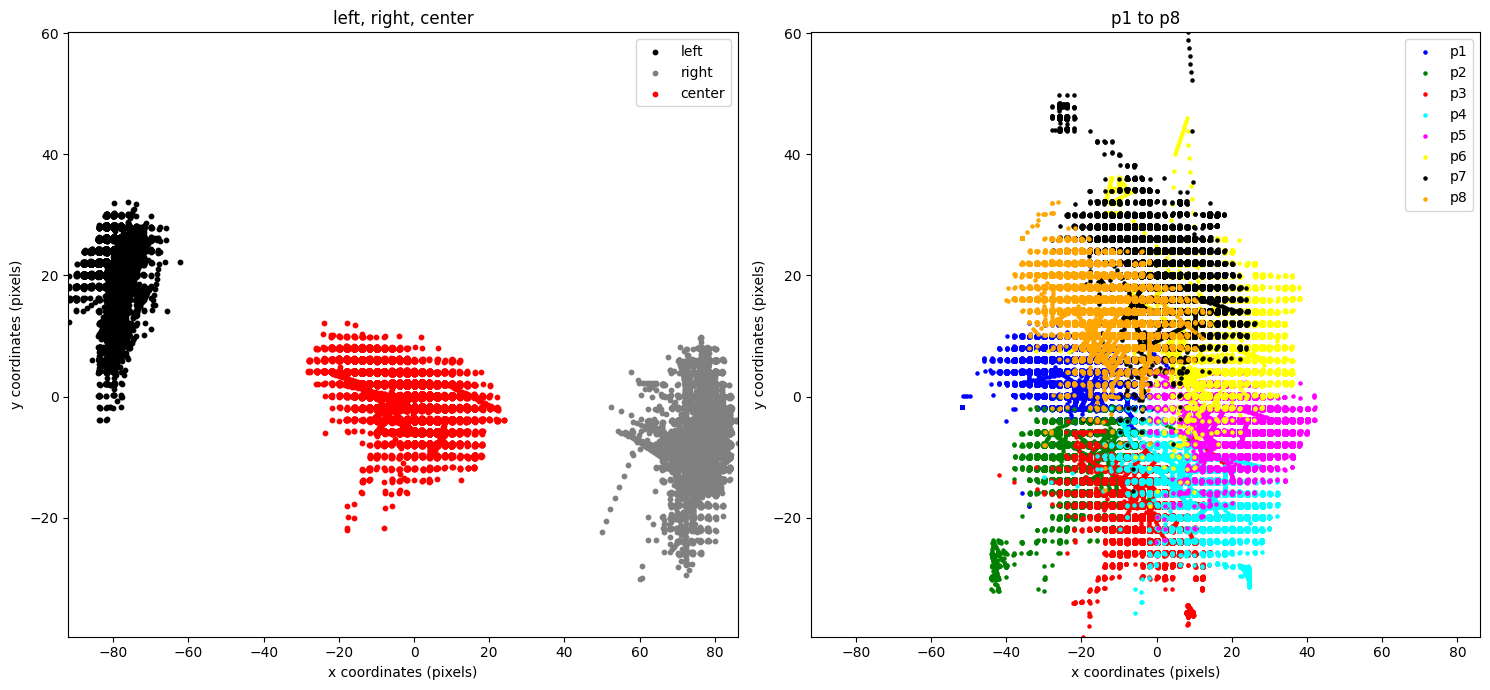

In [9]:
columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']
coordinates_dict=lp.get_coordinates_dict(VideoData1, columns_of_interest)

columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']

# Filter out NaN values and calculate the min and max values for X and Y coordinates
x_min = min([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].min() for col in columns_of_interest])
x_max = max([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].max() for col in columns_of_interest])
y_min = min([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].min() for col in columns_of_interest])
y_max = max([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].max() for col in columns_of_interest])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Plot left, right, and center in the first plot
ax[0].set_title('left, right, center')
ax[0].scatter(coordinates_dict['left.x'], coordinates_dict['left.y'], color='black', label='left', s=10)
ax[0].scatter(coordinates_dict['right.x'], coordinates_dict['right.y'], color='grey', label='right', s=10)
ax[0].scatter(coordinates_dict['center.x'], coordinates_dict['center.y'], color='red', label='center', s=10)
ax[0].set_xlim([x_min, x_max])
ax[0].set_ylim([y_min, y_max])
ax[0].set_xlabel('x coordinates (pixels)')
ax[0].set_ylabel('y coordinates (pixels)')
ax[0].legend(loc='upper right')

# Plot p1 to p8 in the second plot with different colors and smaller markers
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']
for idx, col in enumerate(columns_of_interest[3:]):
    ax[1].scatter(coordinates_dict[f'{col}.x'], coordinates_dict[f'{col}.y'], color=colors[idx], label=col, s=5)

ax[1].set_xlim([x_min, x_max])
ax[1].set_ylim([y_min, y_max])
ax[1].set_title('p1 to p8')
ax[1].set_xlabel('x coordinates (pixels)')
ax[1].set_ylabel('y coordinates (pixels)')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [10]:
############################################################################################################
# fit elypses on the 8 points to determine pupil centre and diameter
############################################################################################################

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']
coordinates_dict=lp.get_coordinates_dict(VideoData1, columns_of_interest)

theta = lp.find_horizontal_axis_angle(VideoData1, 'left', 'center')
center_point = lp.get_left_right_center_point(coordinates_dict)

columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
remformatted_coordinates_dict = lp.get_reformatted_coordinates_dict(coordinates_dict, columns_of_interest)
centered_coordinates_dict = lp.get_centered_coordinates_dict(remformatted_coordinates_dict, center_point)
rotated_coordinates_dict = lp.get_rotated_coordinates_dict(centered_coordinates_dict, theta)

columns_of_interest = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
ellipse_parameters_data, ellipse_center_points_data = lp.get_fitted_ellipse_parameters(rotated_coordinates_dict, columns_of_interest)

average_diameter = np.mean([ellipse_parameters_data[:,0], ellipse_parameters_data[:,1]], axis=0)

SleapVideoData1 = process.convert_arrays_to_dataframe(['Seconds', 'Ellipse.Diameter', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'], [VideoData1['Seconds'].values, average_diameter, ellipse_parameters_data[:,2], ellipse_center_points_data[:,0], ellipse_center_points_data[:,1]])

print("✅ Done calculating pupil diameter and angle")

✅ Done calculating pupil diameter and angle


In [11]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Pupil Diameter", "Pupil Ellipse Long Axis Angle"],
    column_widths=[0.67, 0.33]  # left plot is twice as wide as right plot
)

fig.add_trace(
    go.Scatter(
        x=SleapVideoData1['Seconds'],
        y=SleapVideoData1['Ellipse.Diameter'],
        mode='lines',
        name="Pupil Diameter"
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=SleapVideoData1['Seconds'],
        y=np.degrees(SleapVideoData1['Ellipse.Angle']),
        mode='markers',
        name="Ellipse Angle",
        marker=dict(size=1)
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Seconds", row=1, col=1)
fig.update_yaxes(title_text="Diameter", row=1, col=1)
fig.update_xaxes(title_text="Seconds", row=1, col=2)
fig.update_yaxes(title_text="Angle (degrees)", row=1, col=2)

fig.update_layout(
    height=500,
    width=1200,
    title_text="SLEAP VideoData1: Pupil Metrics"
)

fig.show()

In [12]:
############################################################################################################
# check if Second values match 1:1 between VideoData and SleapVideoData then merge them into VideoData
############################################################################################################

if VideoData1_Has_Sleap is True:
    if VideoData1['Seconds'].equals(SleapVideoData1['Seconds']) is False:
        print("❗ Video1: The 'Seconds' columns DO NOT correspond 1:1 between the two DataFrames. This should not happen")
    else:
        VideoData1 = VideoData1.merge(SleapVideoData1, on='Seconds', how='outer')
        del SleapVideoData1

if VideoData2_Has_Sleap is True:
    if VideoData2['Seconds'].equals(SleapVideoData2['Seconds']) is False:
        print("❗ Video2: The 'Seconds' columns DO NOT correspond 1:1 between the two DataFrames. This should not happen")
    else:
        VideoData2 = VideoData2.merge(SleapVideoData2, on='Seconds', how='outer')
        del SleapVideoData2
gc.collect()
None

R^2 between center point and ellipse center X data: 0.9680
R^2 between center point and ellipse center Y data: 0.5589


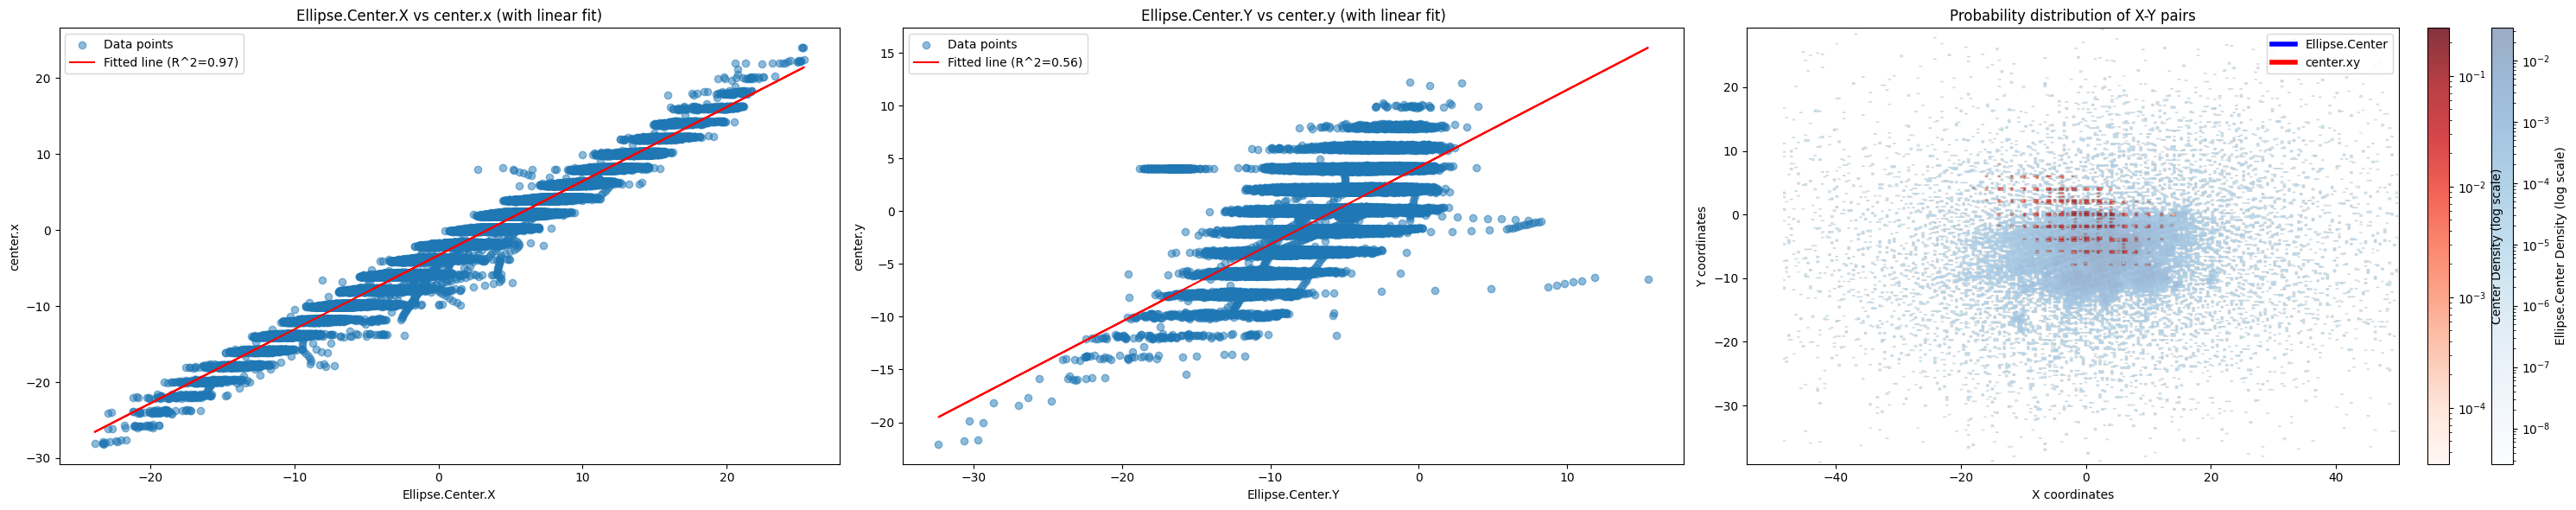

In [13]:
############################################################################################################
# Compare center.x and .y with ellipse.centre.x and .y distributions
############################################################################################################

# ------------------------------------------------------------------
# 1) Compute correlations
# ------------------------------------------------------------------
slope_x, intercept_x, r_value_x, p_value_x, std_err_x = linregress(
    VideoData1["Ellipse.Center.X"], 
    VideoData1["center.x"]
)
r_squared_x = r_value_x**2
print(f"R^2 between center point and ellipse center X data: {r_squared_x:.4f}")

slope_y, intercept_y, r_value_y, p_value_y, std_err_y = linregress(
    VideoData1["Ellipse.Center.Y"], 
    VideoData1["center.y"]
)
r_squared_y = r_value_y**2
print(f"R^2 between center point and ellipse center Y data: {r_squared_y:.4f}")

# ------------------------------------------------------------------
# 2) Create subplots
# ------------------------------------------------------------------
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))

# ------------------------------------------------------------------
# 3) Scatter plots + linear fits
# ------------------------------------------------------------------
# (a) For X data
ax[0].scatter(
    VideoData1["Ellipse.Center.X"], 
    VideoData1["center.x"], 
    alpha=0.5, 
    label="Data points"
)
ax[0].plot(
    VideoData1["Ellipse.Center.X"],
    intercept_x + slope_x * VideoData1["Ellipse.Center.X"],
    "r",
    label=f"Fitted line (R^2={r_squared_x:.2f})"
)
ax[0].set_xlabel("Ellipse.Center.X")
ax[0].set_ylabel("center.x")
ax[0].set_title("Ellipse.Center.X vs center.x (with linear fit)")
ax[0].legend()

# (b) For Y data
ax[1].scatter(
    VideoData1["Ellipse.Center.Y"], 
    VideoData1["center.y"], 
    alpha=0.5, 
    label="Data points"
)
ax[1].plot(
    VideoData1["Ellipse.Center.Y"],
    intercept_y + slope_y * VideoData1["Ellipse.Center.Y"],
    "r",
    label=f"Fitted line (R^2={r_squared_y:.2f})"
)
ax[1].set_xlabel("Ellipse.Center.Y")
ax[1].set_ylabel("center.y")
ax[1].set_title("Ellipse.Center.Y vs center.y (with linear fit)")
ax[1].legend()

# ------------------------------------------------------------------
# 4) 2D KDE for Ellipse.Center (blue)
# ------------------------------------------------------------------
x_ellipse = VideoData1["Ellipse.Center.X"].to_numpy()
y_ellipse = VideoData1["Ellipse.Center.Y"].to_numpy()
data_ellipse = np.vstack([x_ellipse, y_ellipse])

fkde_ellipse = fastKDE(data_ellipse)
pdf_ellipse = fkde_ellipse.pdf
x_axis_ellipse, y_axis_ellipse = fkde_ellipse.axes

im_ellipse = ax[2].imshow(
    pdf_ellipse,
    extent=[x_axis_ellipse.min(), x_axis_ellipse.max(), 
            y_axis_ellipse.min(), y_axis_ellipse.max()],
    aspect="auto",
    origin="lower",
    cmap="Blues",
    alpha=0.4,       # Lower alpha so red can be seen clearly
    norm=LogNorm(),
    zorder=1
)

cbar_ellipse = plt.colorbar(im_ellipse, ax=ax[2], orientation="vertical", fraction=0.046, pad=0.04)
cbar_ellipse.set_label("Ellipse.Center Density (log scale)")

# ------------------------------------------------------------------
# 5) 2D KDE for center (red)
# ------------------------------------------------------------------
x_center = VideoData1["center.x"].to_numpy()
y_center = VideoData1["center.y"].to_numpy()
data_center = np.vstack([x_center, y_center])

fkde_center = fastKDE(data_center)
pdf_center = fkde_center.pdf
x_axis_center, y_axis_center = fkde_center.axes

im_center = ax[2].imshow(
    pdf_center,
    extent=[x_axis_center.min(), x_axis_center.max(), 
            y_axis_center.min(), y_axis_center.max()],
    aspect="auto",
    origin="lower",
    cmap="Reds",
    alpha=0.8,        # Higher alpha to make red more visible
    norm=LogNorm(),
    zorder=2          # Above the blue distribution
)

cbar_center = plt.colorbar(im_center, ax=ax[2], orientation="vertical", fraction=0.046, pad=0.04)
cbar_center.set_label("Center Density (log scale)")

# ------------------------------------------------------------------
# 6) Final formatting
# ------------------------------------------------------------------
ax[2].set_xlabel("X coordinates")
ax[2].set_ylabel("Y coordinates")
ax[2].set_title("Probability distribution of X-Y pairs")

legend_elements = [
    Line2D([0], [0], color="blue", lw=4, label="Ellipse.Center"),
    Line2D([0], [0], color="red",  lw=4, label="center.xy")
]
ax[2].legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.show()


In [14]:
############################################################################################################
# save as df to csv to be loaded in the photometry/harp/etc. analysis notebook 
############################################################################################################
# reindex to aeon datetime to be done in the other notebook
 
if VideoData1_Has_Sleap:
    # Save  DataFrame as CSV to proper path and filename
    save_path1 = save_path / "Video_Sleap_Data1" / "Video_Sleap_Data1_1904-01-01T00-00-00.csv"
    save_path1.parent.mkdir(parents=True, exist_ok=True)
    #save_path1.parent.mkdir(parents=True, exist_ok=True)
    VideoData1.to_csv(save_path1)

if VideoData2_Has_Sleap:
    # Save  DataFrame as CSV to proper path and filename
    save_path2 = save_path / "Video_Sleap_Data2" / "Video_Sleap_Data2_1904-01-01T00-00-00.csv"
    save_path2.parent.mkdir(parents=True, exist_ok=True)
    #save_path2.parent.mkdir(parents=True, exist_ok=True)
    VideoData2.to_csv(save_path2)


# Added forEASY VISUALIZATION, BUT DIRTY, USE SANDBOX_2... INSTEAD GOING FORWARD
## eg saccade amplited are clearly badly detected, 

In [17]:
# detect saccades 
df = VideoData1.copy()

df.index = pd.to_datetime(df.index * (1 / framerate), unit='s')

# 1) Compute velocity (units/s). Filter/diff/filter. Because sample rate is 1000 Hz, diff is * 1000.
window_size = int(round(2 / framerate * 1000))
df["velocity"] = df["Ellipse.Center.X"].rolling(window=window_size, center=True, min_periods=1).mean()
df["velocity"] = df["velocity"].diff() * 1000
window_size = int(round(4 / framerate * 1000))
df["velocity"] = df["velocity"].rolling(window=window_size, center=True, min_periods=1).mean()

# 2) Define a velocity threshold for saccades (adjust as needed)
# implement adaptive filter in the future 

# 3) Create a boolean mask for samples exceeding the threshold
df["is_saccade"] = df["velocity"].abs() > threshold

# 4) Group consecutive saccade samples to form saccade events.
#    Label each contiguous "True" block with a unique ID.
df["saccade_id"] = (df["is_saccade"] & ~df["is_saccade"].shift(fill_value=False)).cumsum() * df["is_saccade"]

# 5) Extract saccade onset times and basic details for each saccade.
saccade_events = []
for sacc_id, group in df.groupby("saccade_id"):
    if sacc_id == 0:
        continue
    saccade_time = group.index[0]
    peak_time = group["velocity"].abs().idxmax()  # Save the time when the absolute velocity peaks
    peak_velocity = group["velocity"].abs().max()
    direction = "positive" if group["velocity"].mean() > 0 else "negative"
    
    saccade_events.append({
        "saccade_id": sacc_id,
        "saccade_time": saccade_time,
        "peak_time": peak_time,         # New column for peak time
        "peak_velocity": peak_velocity,
        "direction": direction
    })

# 6) Apply a refractory period of 50 ms: if 2 saccade events occur within 50 ms, keep only the first.
filtered_saccade_events = []
last_event_time = None  # Initialize as None

for event in saccade_events:
    if last_event_time is None or (event["saccade_time"] - last_event_time) >= refractory_period:
        filtered_saccade_events.append(event)
        last_event_time = event["saccade_time"]


# 7) For each filtered saccade event, calculate the baseline and relative peak.
frame_duration = 1 / framerate  # seconds per frame
for event in filtered_saccade_events:
    saccade_time = event["saccade_time"]
    # Baseline: average the data for 3 frames immediately BEFORE the saccade onset.
    baseline_start = saccade_time - pd.Timedelta(seconds=3 * frame_duration)
    baseline = df.loc[baseline_start:saccade_time, "Ellipse.Center.X"].mean()
    event["baseline"] = baseline

    # Relative peak: in the next 40 ms after the saccade onset, measure the peak change relative to the baseline.
    window_end = saccade_time + pd.Timedelta(milliseconds=500)
    saccade_window = df.loc[saccade_time:window_end, "Ellipse.Center.X"]
    if event["direction"] == "positive":
        relative_peak = saccade_window.max() - baseline
    else:
        relative_peak = baseline - saccade_window.min()
    event["relative_peak"] = relative_peak

# Create a DataFrame of the filtered saccade events including the new metrics.
results_df = pd.DataFrame(filtered_saccade_events)


In [18]:
if plot_saccade_detection_QC:
    pio.renderers.default = 'browser'
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df["velocity"], mode="lines", name="Velocity", line=dict(color="lightgrey", width=1)))
    fig.add_trace(go.Scatter(x=df.index, y=df["Ellipse.Center.X"], mode="lines", name="Ellipse.Center.X", line=dict(color="darkgrey", width=1), yaxis="y2"))
    if not results_df.empty:
        pos_df = results_df[results_df["direction"] == "positive"]
        neg_df = results_df[results_df["direction"] == "negative"]
        if not pos_df.empty:
            pos_starts = pos_df["saccade_time"]
            pos_y = df.loc[pos_starts, "Ellipse.Center.X"]
            fig.add_trace(go.Scatter(x=pos_starts, y=pos_y, mode="markers",
                                     marker=dict(symbol="circle-open", size=10, line=dict(width=2, color="red")),
                                     name="Positive Saccade Onsets", yaxis="y2"))
        if not neg_df.empty:
            neg_starts = neg_df["saccade_time"]
            neg_y = df.loc[neg_starts, "Ellipse.Center.X"]
            fig.add_trace(go.Scatter(x=neg_starts, y=neg_y, mode="markers",
                                     marker=dict(symbol="circle-open", size=10, line=dict(width=2, color="blue")),
                                     name="Negative Saccade Onsets", yaxis="y2"))
    fig.update_layout(
        title="Velocity and Ellipse.Center.X",
        xaxis_title="Time",
        yaxis=dict(title="Velocity"),
        yaxis2=dict(title="Ellipse.Center.X", overlaying="y", side="right")
    )
    fig.show()


In [19]:
############################################################################################################
# INVESTIGATE issue of long stretches of consecutive very low inference predicition scores 
############################################################################################################


score_cutoff = 0.0000001
columns_of_interest = ['left.score','center.score','right.score','p1.score','p2.score','p3.score','p4.score','p5.score','p6.score','p7.score','p8.score']
total_points = len(VideoData1)


for col in columns_of_interest:
    count_below_threshold = (VideoData1[col] < score_cutoff).sum()
    percentage_below_threshold = (count_below_threshold / total_points) * 100
    
    # Find the longest consecutive series below threshold
    below_threshold = VideoData1[col] < score_cutoff
    longest_series = 0
    current_series = 0
    
    for value in below_threshold:
        if value:
            current_series += 1
            if current_series > longest_series:
                longest_series = current_series
        else:
            current_series = 0
    
    print(f"Column: {col} | Values below {score_cutoff}: {count_below_threshold} ({percentage_below_threshold:.2f}%) | Longest consecutive frame series: {longest_series}")


Column: left.score | Values below 1e-07: 2526 (2.26%) | Longest consecutive frame series: 360
Column: center.score | Values below 1e-07: 601 (0.54%) | Longest consecutive frame series: 294
Column: right.score | Values below 1e-07: 4414 (3.95%) | Longest consecutive frame series: 101
Column: p1.score | Values below 1e-07: 538 (0.48%) | Longest consecutive frame series: 274
Column: p2.score | Values below 1e-07: 415 (0.37%) | Longest consecutive frame series: 59
Column: p3.score | Values below 1e-07: 406 (0.36%) | Longest consecutive frame series: 42
Column: p4.score | Values below 1e-07: 634 (0.57%) | Longest consecutive frame series: 118
Column: p5.score | Values below 1e-07: 632 (0.57%) | Longest consecutive frame series: 278
Column: p6.score | Values below 1e-07: 565 (0.51%) | Longest consecutive frame series: 63
Column: p7.score | Values below 1e-07: 319 (0.29%) | Longest consecutive frame series: 40
Column: p8.score | Values below 1e-07: 570 (0.51%) | Longest consecutive frame seri

In [20]:
pympler_memory_df = utils.get_pympler_memory_usage(top_n=10)

⚠️ Skipping im_ellipse: invalid option: reset(base=-1789568)
⚠️ Skipping cbar_ellipse: invalid option: reset(base=-1789568)
⚠️ Skipping im_center: invalid option: reset(base=-1789568)
⚠️ Skipping cbar_center: invalid option: reset(base=-1789568)
🔹 Top Memory-Consuming Variables (in MB):


Variable  Size (MB)
136                             df  40.834543
54                coordinates_dict  37.557358
49                      VideoData1  34.136478
95   remformatted_coordinates_dict  18.777382
97        rotated_coordinates_dict  18.777382
96       centered_coordinates_dict  18.777382
121                   fkde_ellipse  10.378876
128                    fkde_center   8.536057
63                             fig   3.541107
98         ellipse_parameters_data   2.560226


🔹 Total Memory Used: 211.01 MB
